# Using gradient boosting trees to predict medical insurance charges 

#### dataset is taken from Kaggle: https://www.kaggle.com/mirichoi0218/insurance.  

## Conclusions
- Smoking status is the #1 predictor of medical insurance charges, followed by BMI and age
- Geographical locations and age do not seem to play big roles in predicting medical insurance charges
- The prediction is more accurate on smokers vs. non-smokers. 
- Although the loss (MSE) on validation set was not tiny after training on the training set, the perforamnce on test set showed a comparable loss.
- Gradient boosting tree predicted a slightly higher insurance charege than the real values in test set. 
- Other regression based/non-regression based algorithms can be tested to see which method works the best for this problem. 

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import seaborn as sns
from scipy.stats import mannwhitneyu

In [22]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [23]:
# get the number of NAs in each column
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [24]:
#get an idea of categorical variable distribution
print('# of sex\n',data.sex.value_counts())
print('# of children\n', data.children.value_counts())
print('# of smokers\n', data.smoker.value_counts())
print('# of region\n', data.region.value_counts())

# of sex
 male      676
female    662
Name: sex, dtype: int64
# of children
 0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64
# of smokers
 no     1064
yes     274
Name: smoker, dtype: int64
# of region
 southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


### recode binary/categorical variables to numerical

In [25]:
#data.iloc[:, ['sex','smoker','region']] = data.iloc[:, ['sex','smoker','region']].astype(int)
data['Sex'] = data['sex'].map({'male':1, 'female':0})
data['Smoker'] = data['smoker'].map({'yes':1, 'no':0})
data_region = pd.get_dummies(data.region, prefix='region')
data = data.drop(columns = ['sex', 'smoker', 'region'])

In [26]:
data_x_name = data.columns.to_list() + data_region.columns.to_list()
data_x = pd.concat([data, data_region],  axis =1, names=data_x_name)
data_x.head()

,age,bmi,children,charges,Sex,Smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [27]:
data_x.shape

(1338, 10)

## data visualization

#### distribution of the outcome: charges

Text(0, 0.5, 'frequency')

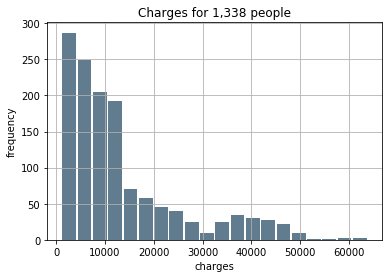

In [28]:
import matplotlib.pyplot as plt
data_x['charges'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Charges for 1,338 people')
plt.xlabel('charges')
plt.ylabel('frequency')
#plt.grid(axis='y', alpha=0.75)

#### correlation patterns of continous variables -  looks like the influence of factors are in this order: age > bmi >children

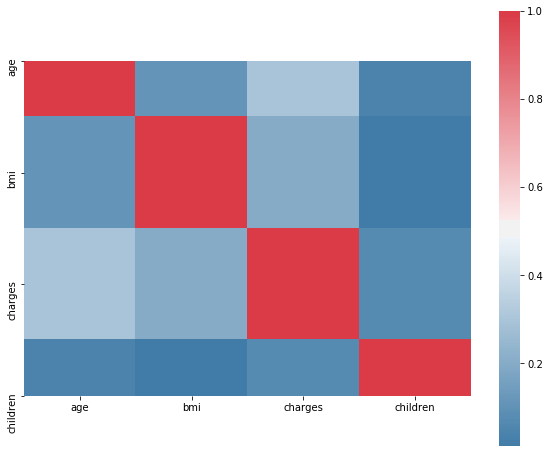

In [29]:
f, ax = pl.subplots(figsize=(10, 8))
corr = data.loc[:, ['age', 'bmi','charges','children']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

#### mannwhitney U test to see what categorical variables are associated with the outcome (ANOVA is not used since the outcome doesn't seem to be normally distributed)

In [30]:
for var in ['Sex', 'Smoker',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest']:
    data_x_group_a = data_x['charges'][data_x[var]==0]
    data_x_group_b = data_x['charges'][data_x[var]==1]
    _, p = mannwhitneyu(data_x_group_a, data_x_group_b, alternative = "two-sided")
    if p <0.05:
        print(var, p)

Smoker 5.270233444503571e-130


### split data for gradient boosting trees

In [31]:
X = data_x.drop(columns = ['charges'])
y = data_x['charges']
print(X.shape, y.shape)

(1338, 9) (1338,)


In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train_val, X_test, y_train_val, y_test = train_test_split(
   X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
   X_train_val, y_train_val, test_size=0.15, random_state=0)
print(X_train.shape,  y_train.shape, X_val.shape, y_val.shape, X_test.shape,y_test.shape)

(966, 9) (966,) (171, 9) (171,) (201, 9) (201,)


### Look at the learning rate's influence on accuracy in validation set

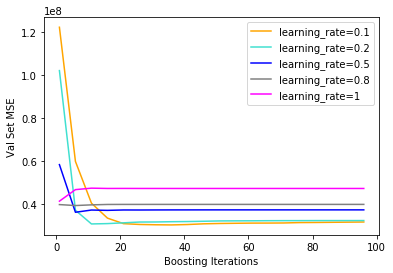

In [33]:
original_params = {'loss' : 'ls','n_estimators': 100, 'max_leaf_nodes': None, 'max_depth': 10, 'random_state': 2,
                   'min_samples_split': 5,'subsample': 1.0}

plt.figure()

for label, color, setting in [('learning_rate=0.1', 'orange',
                               {'learning_rate': 0.1}),
                              ('learning_rate=0.2', 'turquoise',
                               {'learning_rate': 0.2}),
                              ('learning_rate=0.5', 'blue',
                               {'learning_rate': 0.5}),
                              ('learning_rate=0.8', 'gray',
                               {'learning_rate': 0.8}),
                              ('learning_rate=1', 'magenta',
                               {'learning_rate': 1})]:
    params = original_params
    params.update(setting)

    reg = GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    # compute test set loss
    val_mse = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(reg.staged_predict(X_val)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        val_mse[i] = reg.loss_(y_val, y_pred)
        

    plt.plot((np.arange(val_mse.shape[0]) + 1)[::5], val_mse[::5],
            '-', color=color, label=label)

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Val Set MSE')

plt.show()

##### Learning rate =0.1 seemed ideal 

### look at the influence of max_depth in validation set

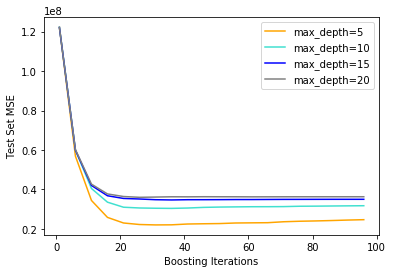

In [35]:
original_params = {'loss' : 'ls','n_estimators': 100, 'max_leaf_nodes': None, 'max_depth': 10, 'random_state': 2,
                   'min_samples_split': 5,'subsample': 1.0, 'learning_rate': 0.1}

plt.figure()

for label, color, setting in [('max_depth=5', 'orange',
                               {'max_depth': 5}),
                              ('max_depth=10', 'turquoise',
                               {'max_depth': 10}),
                              ('max_depth=15', 'blue',
                               {'max_depth': 15}),
                              ('max_depth=20', 'gray',
                               {'max_depth': 20})
                                ]:
    params = original_params
    params.update(setting)

    reg = GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    # compute test set loss
    val_mse = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(reg.staged_predict(X_val)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        val_mse[i] = reg.loss_(y_val, y_pred)

    plt.plot((np.arange(val_mse.shape[0]) + 1)[::5], val_mse[::5],
            '-', color=color, label=label)

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set MSE')

plt.show()

#### max_depth as 5 seemed ideal, although there is a slight overfitting

## make predition on test set

In [36]:
original_params = {'loss' : 'ls','n_estimators': 90, 'max_leaf_nodes': None, 'max_depth': 5, 'random_state': 2,
                   'min_samples_split': 5,'subsample': 1.0, 'learning_rate': 0.1}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train_val, y_train_val)
pred_test = reg.predict(X_test)
test_set_mse = mean_squared_error(pred_test, y_test)
print('the test set mse is {}'.format(test_set_mse))

the test set mse is 39364610.03138133


In [16]:
### plot validation and test set MSE

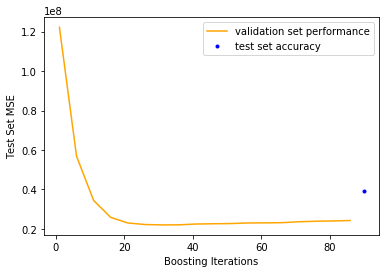

In [17]:
plt.figure()

params = {'loss' : 'ls','n_estimators': 90, 'max_leaf_nodes': None, 'max_depth': 5, 'random_state': 2,
                   'min_samples_split': 5,'subsample': 1.0, 'learning_rate': 0.1}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

# compute test set loss
val_mse = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(X_val)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
    val_mse[i] = reg.loss_(y_val, y_pred)

plt.plot((np.arange(val_mse.shape[0]) + 1)[::5], val_mse[::5],
        '-', color='orange', label='validation set performance')
plt.plot(90, test_set_mse, '.',color = 'blue', label = 'test set accuracy')

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set MSE')

plt.show()

## test set pred vs. test set true

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


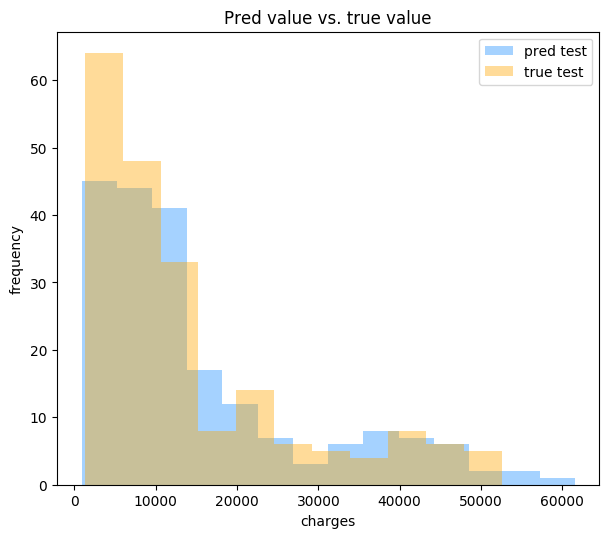

In [18]:
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot( pred_test ,kde=False,  color="dodgerblue", label="pred test")
sns.distplot( y_test ,kde = False,  color="orange", label="true test")
#bins =1000

plt.title('Pred value vs. true value')
plt.ylabel('frequency')
plt.legend();

#### correlation pattern between y_pred and y_true

In [51]:
test = pd.concat([X_test, pd.Series(y_test)],axis =1)
test['pred_charges'] = pred_test
test.head()

,age,bmi,children,Sex,Smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges,pred_charges
578,52,30.200,1,1,0,0,0,0,1,9724.53000,9553.270640
610,47,29.370,1,0,0,0,0,1,0,8547.69130,8793.190290
569,48,40.565,2,1,1,0,1,0,0,45702.02235,43284.685353
1034,61,38.380,0,1,0,0,1,0,0,12950.07120,12645.088552
198,51,18.050,0,0,0,0,1,0,0,9644.25250,9052.051963


Text(0.5, 1.0, 'Predicted charges vs. true charges on test set stratified by smoking status')

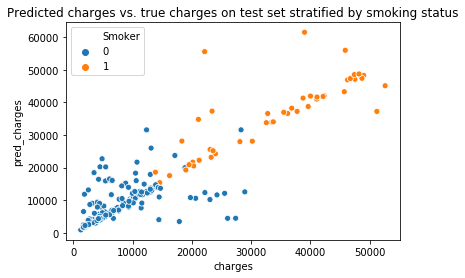

In [53]:
ax = sns.scatterplot(x="charges", y="pred_charges", hue="Smoker",
                     data=test)
ax.set_title('Predicted charges vs. true charges on test set stratified by smoking status')

#### the prediction is more accurate on smokers rather than on smokers, and in general smokers have higher charges

### rank top predictors

In [19]:
col = data_x.columns.to_list()
col.remove('charges')
pd.DataFrame({'col': col, 'rank': reg.feature_importances_}).sort_values(by = "rank", ascending =False)

,col,rank
4,Smoker,0.647152
1,bmi,0.210724
0,age,0.115960
2,children,0.013210
5,region_northeast,0.006018
3,Sex,0.003160
6,region_northwest,0.001547
7,region_southeast,0.001302
8,region_southwest,0.000929
